# Set up

Python librairies imports :

In [1]:
# File system management
import os
from pathlib import Path
import io

# Data manipulation
import numpy as np
import pandas as pd
from typing import Iterator

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image manipulation
from PIL import Image

# Dimension reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Pyspark
from pyspark.ml.feature import PCA as pyPCA
from pyspark.ml.functions import array_to_vector
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

%matplotlib inline
sns.set_theme(palette="Set2")

Define work location :

In [2]:
# Current project path
PATH_PROJ = "/Users/victor/Documents/OPENCLASSROOMS/projet_8"

# Define images paths
PATH_DATA = PATH_PROJ + "/data/training"
PATH_RESULTS = PATH_PROJ + "/data/results"

# Change directory
os.chdir(PATH_PROJ)

# Data exploration

In [3]:
# Count images
img_count = len([f for f in Path(PATH_DATA).rglob('*.jpg') if f.is_file()])
print("Number of JPG files in " + PATH_DATA + " : " + str(img_count))

Number of JPG files in /Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training : 6231


In [4]:
# Create list of images
images_list = [(file_name, dir_path.split('/')[-1]) for (dir_path, _, file_names) in os.walk(PATH_DATA) \
               for file_name in file_names if file_name.endswith('.jpg')]

# Create dataframe
images_df = pd.DataFrame(images_list, columns=['image', 'label'])

# Add categories
images_df['category'] = images_df['label'].apply(lambda x: x.split('_')[0]) 
display(images_df.head())

,image,label,category
0,r0_190.jpg,cucumber_3,cucumber
1,r0_184.jpg,cucumber_3,cucumber
2,r0_52.jpg,cucumber_3,cucumber
3,r0_46.jpg,cucumber_3,cucumber
4,r0_8.jpg,cucumber_3,cucumber


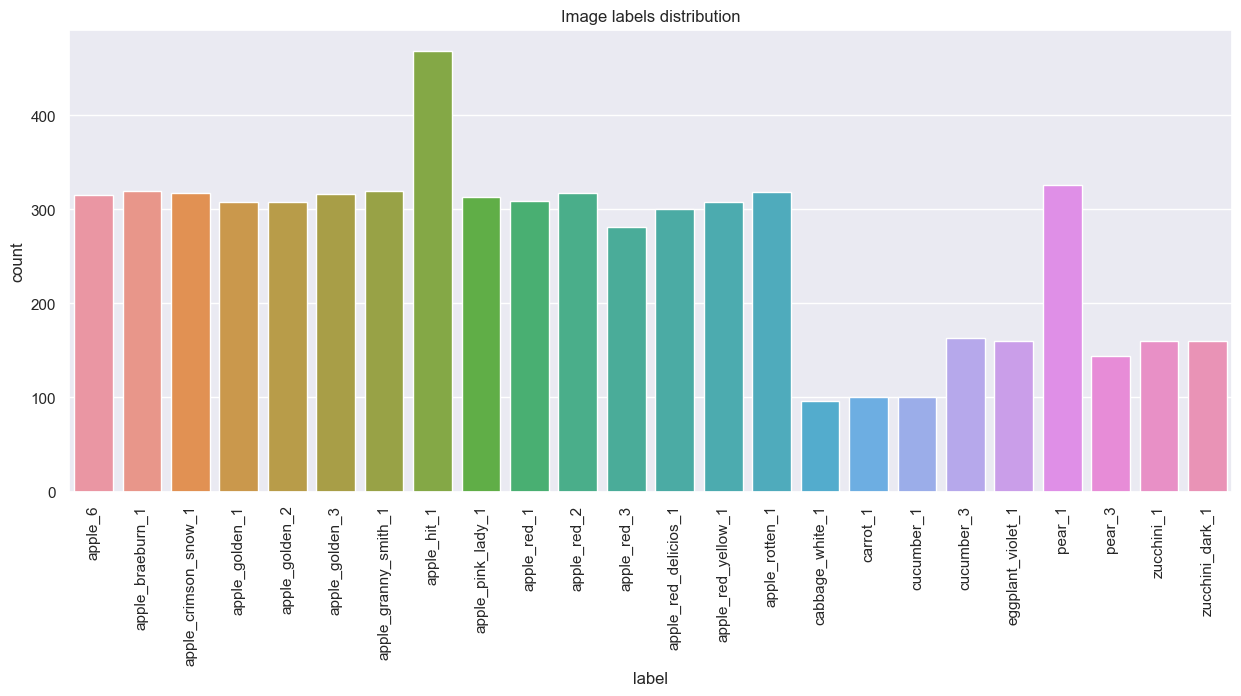

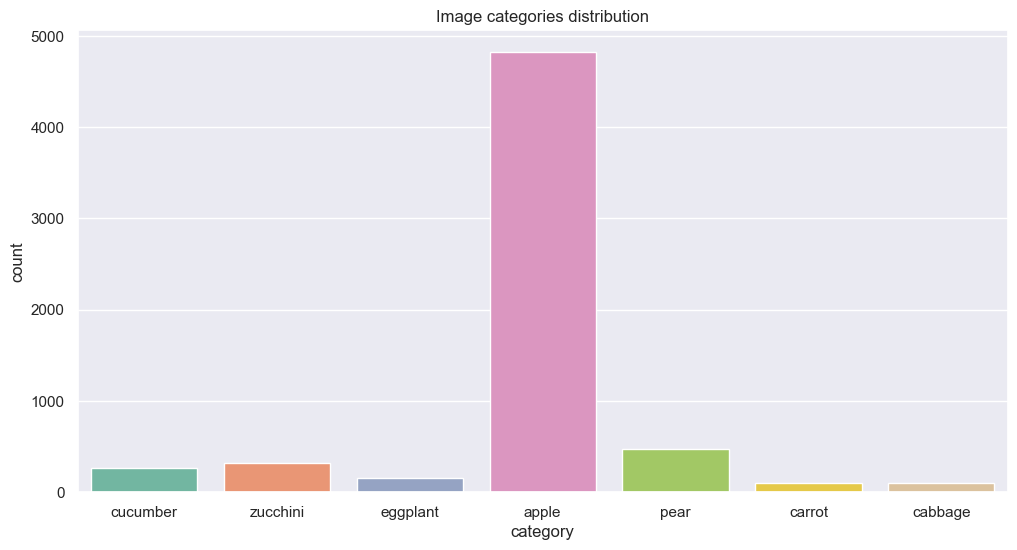

In [5]:
# Display image labels
plt.figure(figsize=(15, 6))
plt.title("Image labels distribution")
sns.countplot(x=images_df['label'].sort_values())
plt.xticks(rotation=90)
plt.show()

# Display image categories
plt.figure(figsize=(12, 6))
plt.title("Image categories distribution")
sns.countplot(x=images_df['category'])
# plt.xticks(rotation=90)
plt.show()

# Data processing

## Functions

### MobileNetV2 model

In [24]:
def model_create(show_summary=False):
    """Create a MobileNetV2 model with top layer removed

    Returns:
        MobileNetV2 model
    """
    # Load default model
    model_base = MobileNetV2(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

    # Freeze layers
    for layer in model_base.layers:
        layer.trainable = False

    # Create model without top layer
    model_new = Model(inputs=model_base.input, outputs=model_base.layers[-2].output)

    # Show model summary
    if show_summary is True:
        print(model_new.summary())

    return model_new

### Images preprocesssing

In [7]:
def preprocess(content):
    """Preprocesses raw image bytes.

    Args:
        content: PIL Image

    Returns:
        Numpy array
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

In [8]:
def featurize_series(model, content_series):
    """Featurize a pd.Series of raw images using the input model.

    Args:
        model: CNN model
        content_series: pd.Series of image data

    Returns:
        pd.Series of image features
    """
    content_input = np.stack(content_series.map(preprocess))
    preds = model.predict(content_input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

## Distributed model inference

### Create the Spark session

In [9]:
# Create sparkSession
spark = (SparkSession
         .builder
         .appName('oc_p8')
         .master('local')
         .config("spark.sql.parquet.writeLegacyFormat", 'true')
         .config("spark.driver.bindAddress","127.0.0.1")
         .getOrCreate())

# Create sparkContext
sc = spark.sparkContext

# Set log level
sc.setLogLevel("ERROR")

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/09 11:52:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Broadcast the model weights

In [26]:
# Broadcast weights of mobile net v2 model
broadcast_weights = spark.sparkContext.broadcast(model_create(show_summary=True).get_weights())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
@F.pandas_udf("array<float>")
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    """This method is a Scalar Iterator pandas UDF wrapping our featurization function.
        The decorator specifies this returns a Spark DataFrame column of type ArrayType(FloatType).

    Args:
        content_series_iter: Iterator over batches of data, where each batch
                            is a pandas Series of image data.

    Yields:
        pd.Series of image features
    """
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_create()
    # Broadcast weights to workers
    model.set_weights(broadcast_weights.value)
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

### Load the images

In [12]:
# Load all images
images = spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg").option("recursiveFileLookup", "true").load(PATH_DATA)

In [13]:
# Display first images
images = images.withColumn('label', F.element_at(F.split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))
print("Number of images loaded : ", images.count())

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None


+-----------------------------------------------------------------------------------------+-----------+
|path                                                                                     |label      |
+-----------------------------------------------------------------------------------------+-----------+
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_116.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_114.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_108.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_118.jpg|apple_hit_1|
|file:/Users/victor/Documents/OPENCLASSROOMS/projet_8/data/training/apple_hit_1/r0_120.jpg|apple_hit_1|
+-----------------------------------------------------------------------------------------+-----------+
only showing top 5 rows

None


Number of images loaded :  6231


### Run the model inference

In [ ]:
# Select 10% of dataset for local test
images_sample = images.sample(fraction=0.1, seed=42)
display(images_sample.show(5))
display(images_sample.printSchema())
print("Number of images : ", images_sample.count())

In [20]:
# Create the image features
features_df = images_sample.repartition(20).select(F.col("path"), F.col("label"),
                                                   featurize_udf("content").alias('features'))

# Create the vectors
features_df = features_df.withColumn('features_vec', array_to_vector("features"))

display(features_df.show(5))
display(features_df.printSchema())

2023-03-08 15:40:56.922692: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


+--------------------+-----------+--------------------+--------------------+
|                path|      label|            features|        features_vec|
+--------------------+-----------+--------------------+--------------------+
|file:/Users/victo...|apple_hit_1|[0.3222898, 0.459...|[0.32228979468345...|
|file:/Users/victo...|apple_hit_1|[1.1753603, 0.059...|[1.17536032199859...|
|file:/Users/victo...| cucumber_3|[1.5150166, 0.201...|[1.51501655578613...|
|file:/Users/victo...|apple_red_3|[0.5331319, 0.003...|[0.53313189744949...|
|file:/Users/victo...|     pear_3|[0.6971466, 0.223...|[0.69714659452438...|
+--------------------+-----------+--------------------+--------------------+
only showing top 5 rows



None

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)



None

23/03/08 23:02:22 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 918965 ms exceeds timeout 120000 ms
23/03/08 23:02:22 WARN SparkContext: Killing executors is not supported by current scheduler.
23/03/08 23:02:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 58816)
Traceback (most recent call last):
  File "/Users/victor/miniconda3/envs/openclassrooms/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/victor/miniconda3/envs/openclassrooms/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/victor/miniconda3/envs/openclassrooms/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/victor/miniconda3/envs/openclassrooms/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/victor/miniconda3/envs/openclassrooms/lib/python3.10/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/Users/victor/miniconda3/envs/openclassrooms/lib/pyth

In [17]:
# Save results as parquet files
features_df.write.mode("overwrite").parquet(PATH_RESULTS)

2023-03-08 12:58:45.698345: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Dimension reduction

In [18]:
# Load results as a dataframe
res_df = pd.read_parquet(PATH_RESULTS, engine='pyarrow')

display(res_df.head())

,path,label,features,features_vec
0,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,apple_hit_1,"[0.3222898, 0.45961368, 0.06672078, 0.0, 0.012...","{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,apple_hit_1,"[1.1753603, 0.059681173, 0.76340306, 0.0, 0.02...","{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,cucumber_3,"[1.5150166, 0.20115007, 0.0851328, 0.000481274...","{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,apple_red_3,"[0.5331319, 0.0039223554, 0.0039826315, 0.0, 0...","{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/Users/victor/Documents/OPENCLASSROOMS/pr...,pear_3,"[0.6971466, 0.22352776, 0.23542322, 0.0, 0.0, ...","{'type': 1, 'size': None, 'indices': None, 'va..."


In [19]:
# Number features
features_n = res_df.loc[0, 'features'].shape[0]
print("The dimension of the features is", features_n)

The dimension of the features is 1280


### TSNE

,TSNE1,TSNE2,label
0,-10.631801,-16.487476,apple_hit_1
1,-18.426191,-4.225595,apple_hit_1
2,-38.115704,3.932937,cucumber_3
3,23.358810,-16.260616,apple_red_3
4,9.104359,-25.722828,pear_3


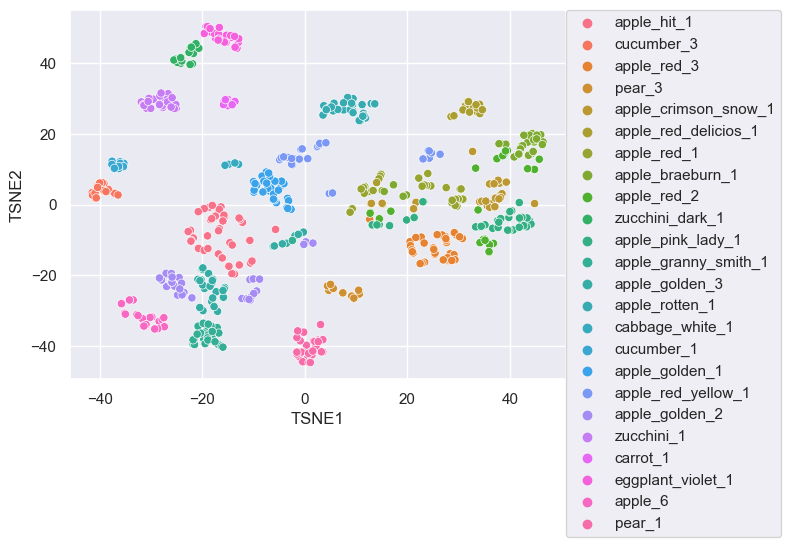

In [20]:
# Extract features
features = pd.DataFrame(res_df['features'].values.tolist(), index=res_df.index)

# Create t-sne dataframe
tsne_df = pd.DataFrame(TSNE(perplexity=20).fit_transform(features), columns=['TSNE1', 'TSNE2'])

# Add label
tsne_df['label'] = res_df['label']
display(tsne_df.head())

# Display scatterplot
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='label')
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
plt.show()

### Sklearn PCA

In [ ]:
# Number of components
PCA_K = 100

In [22]:
# Create PCA model
pca = PCA(n_components=PCA_K)

# Fit to data 
pca_data = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_data, columns=['PCA'+str(i) for i in range(1, pca_data.shape[1]+1)])
display(pca_df.head())


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA91,PCA92,PCA93,PCA94,PCA95,PCA96,PCA97,PCA98,PCA99,PCA100
0,-5.406526,-6.325706,3.277794,1.652389,-1.239293,4.288013,1.269371,-4.382606,1.615676,0.599263,...,0.372526,0.138661,-0.097141,0.446995,0.102054,0.521286,1.154262,-0.089753,0.398554,0.189854
1,-6.856070,-2.294330,-2.866755,-2.737628,1.549383,3.624330,1.760015,-3.727599,-2.141563,2.609695,...,-0.083608,0.635517,0.785314,-0.178664,0.308305,0.675803,-0.057273,0.858459,-0.118706,-0.894056
2,-6.793594,6.898516,2.120455,-7.872385,2.867373,4.054110,-5.981020,4.276595,0.890332,-3.616580,...,0.084486,-0.024920,-0.140127,-0.362197,-0.267220,0.227834,-0.154386,-0.875102,0.221377,-0.191538
3,4.206675,-1.385420,-1.109063,0.360160,3.286676,0.513487,1.780781,-0.205080,-3.028687,-2.126337,...,-0.111362,0.475418,0.260290,-0.284214,0.144451,0.899801,0.478751,-0.123178,0.118308,-0.217748
4,1.424644,-3.818302,2.080121,-2.695063,5.127022,1.514199,-0.695871,-4.071542,0.801493,0.268094,...,0.411624,0.219891,-0.470471,-0.562469,-0.110172,-0.172477,-0.345779,-0.342210,-0.147767,0.411558


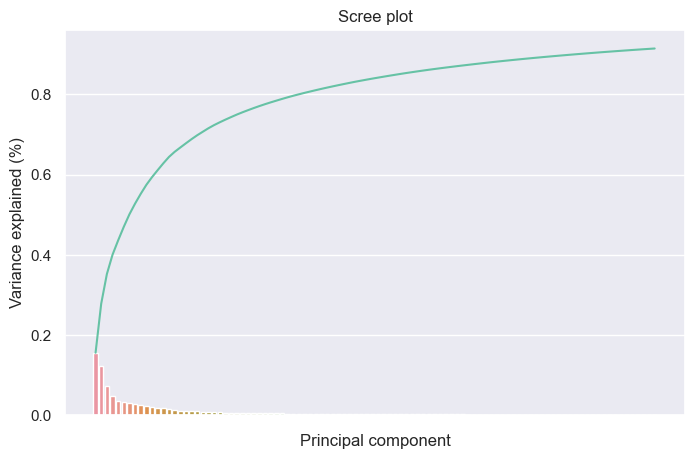

In [24]:
# Get explained variance ratio
pca_evr = list(pca.explained_variance_ratio_)
pca_evr_cumsum = np.cumsum(pca_evr)

# Display 
plt.figure(figsize=(8, 5))
plt.title("Scree plot")
sns.barplot(x=pca_df.columns, y=pca_evr)
sns.lineplot(x=pca_df.columns, y=pca_evr_cumsum)
plt.xlabel('Principal component')
plt.xticks('')
plt.ylabel('Variance explained (%)')
plt.show()

In [25]:
# Find thresholds
for th_val in [0.8, 0.85, 0.90, 0.95, 100]:
    th_idx = np.argmax(pca_evr_cumsum > th_val)
    if th_idx > 0:
        print('{:.0%} of the variance is explained by {} principal components ({:.4})' \
              .format(th_val, th_idx+1, pca_evr_cumsum[th_idx]))

# Show 100e component
print('{:.0%} of the variance is explained by {} principal components ({:.4})' \
              .format(pca_evr_cumsum[99], 100, pca_evr_cumsum[99]))


80% of the variance is explained by 37 principal components (0.8003)
85% of the variance is explained by 55 principal components (0.8512)
90% of the variance is explained by 86 principal components (0.9001)
91% of the variance is explained by 100 principal components (0.9145)


### Pyspark PCA

In [ ]:
# Create pyspark PCA model
pca = pyPCA(k=PCA_K, inputCol='features_vec', outputCol='features_pca')

# Fit model
pca_model = pca.fit(features_df)

# Transform data
pca_data = pca_model.transform(features_df)

display(features_df.show(5))
display(features_df.printSchema())

23/03/08 13:05:07 ERROR RetryingBlockTransferor: Exception while beginning fetch of 1 outstanding blocks (after 1 retries)
java.io.IOException: Connecting to nc-ass-vip.sdv.fr/212.95.74.75:56997 failed in the last 4750 ms, fail this connection directly
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:214)
	at org.apache.spark.network.netty.NettyBlockTransferService$$anon$2.createAndStart(NettyBlockTransferService.scala:126)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.transferAllOutstanding(RetryingBlockTransferor.java:173)
	at org.apache.spark.network.shuffle.RetryingBlockTransferor.lambda$initiateRetry$0(RetryingBlockTransferor.java:206)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoo